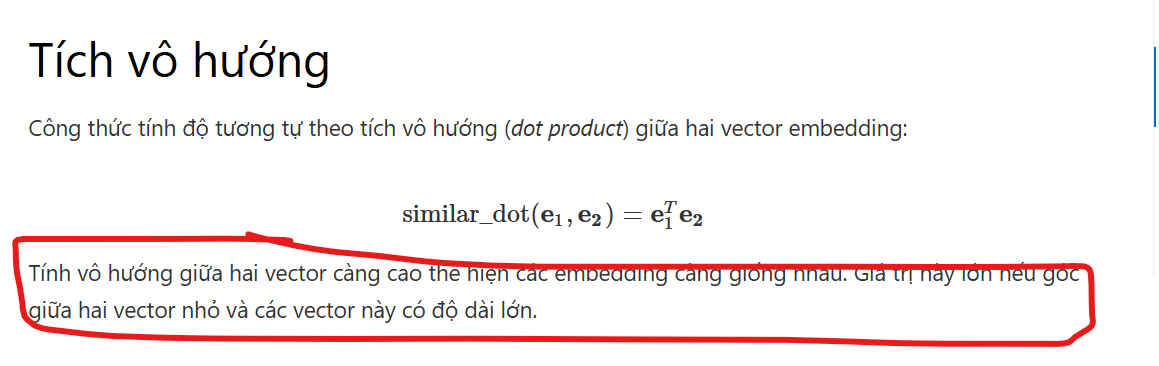

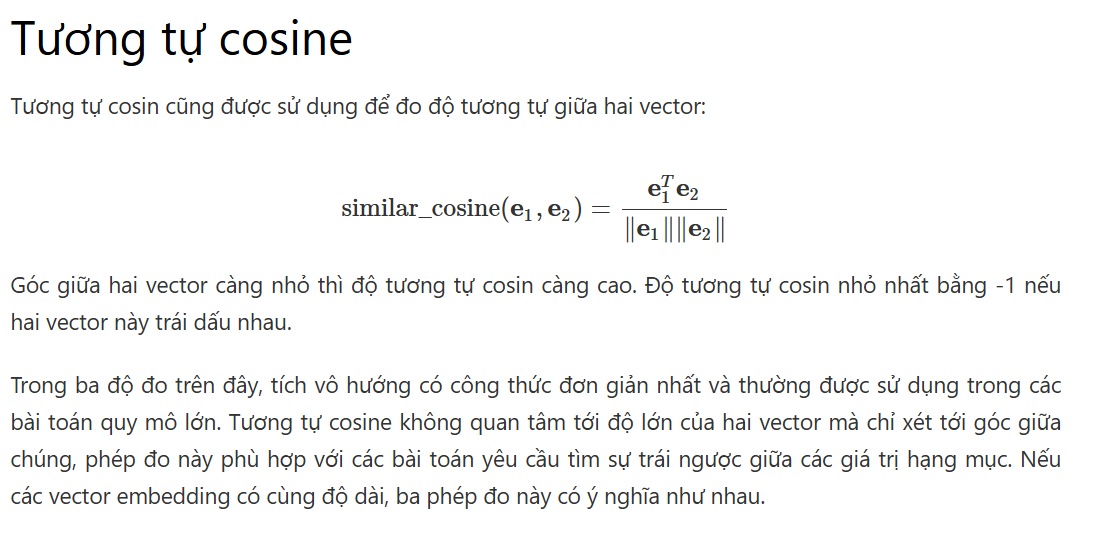

Hãy cùng suy ngẫm về thiết kế word2vec bằng cách lấy mô hình Skip-gram làm ví dụ. Mối quan hệ giữa tích số chấm của hai vectơ từ trong mô hình Skip-gram và độ tương tự cosine là gì?

**Theo biểu thức** thì chúng cùng có một tỷ lệ với tích vô hướng

Đối với một cặp từ có ngữ nghĩa tương tự nhau, tại sao độ tương tự cosin của vectơ từ của chúng (được huấn luyện bằng mô hình Skip-gram) có thể cao?

Ở trên biểu thức công thức euclid thì 2 vector càng gần nhau thì càng nhỏ, consine = dot(u,v)/||u||.|v|| dẫn đến một số mà / cho một số gần = 0 thì chúng càng lớn

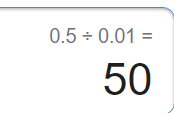

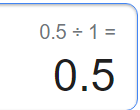

đó là lý do mà cosine ko được sử dụng trong word2vec thì nếu chia cho một số gần bằng 0 (tức 0.00000000000000000000000...1) thì nó sẽ trở nên quá lớn và bằng vô cực ảnh hưởng đến khả năng tính toán của máy tính

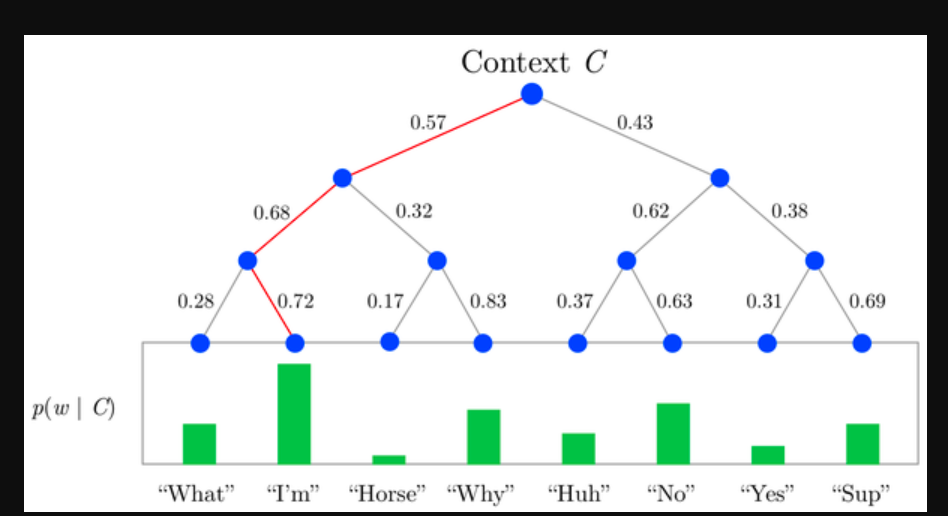

xem thêm : https://medium.com/@gridflowai/optimizing-word2vec-with-hierarchical-softmax-a9d46ebe545a#:~:text=Hierarchical%20SoftMax%20offers%20a%20solution%20to%20mitigate%20the%20computational%20burden

có 2 bias bj và cj đảm bảo sự đối xứng xij = xji



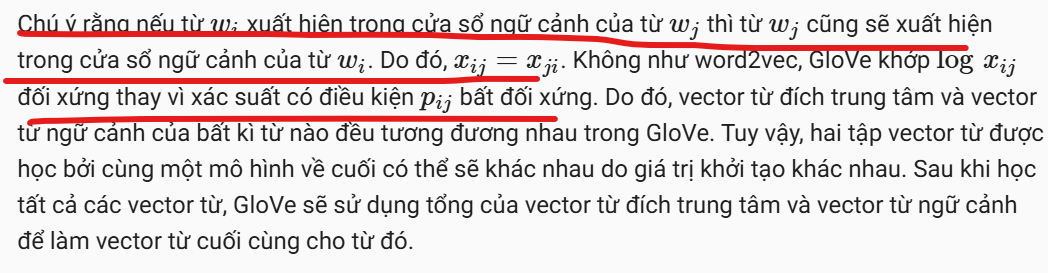

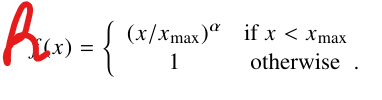F

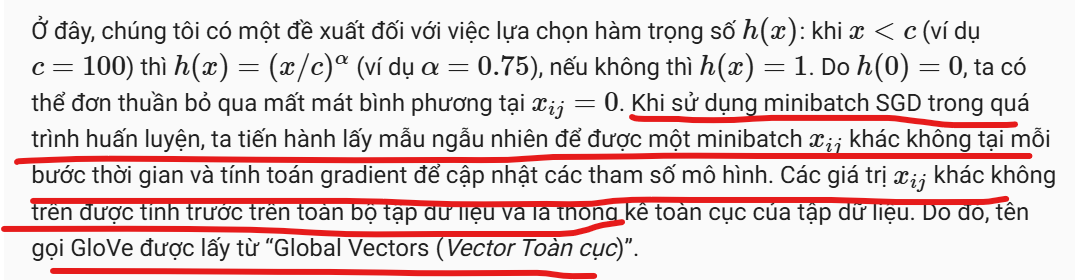

Giải thích cái tên được hiểu ở các gạch đỏ

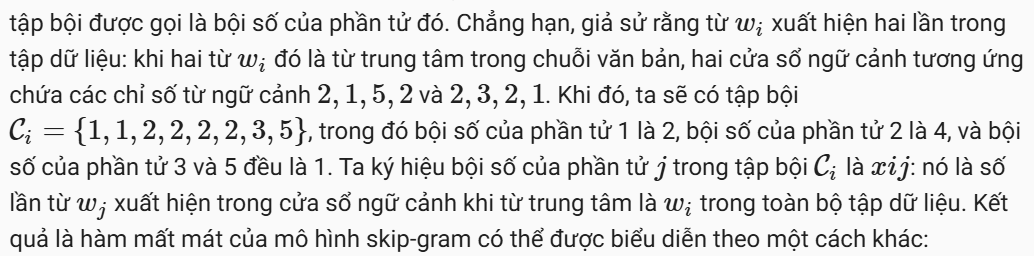

Giải thích công thức h(x) giải sử là c = 100 (therod) khi xij là bội của phần j trong Ci lớn > c thì chúng bằng 1 và nó không phạt không làm giảm mối quan hệ giữa 2 từ, khi xij < c thì nó sẽ phạt bằng cách mũ 0.75   

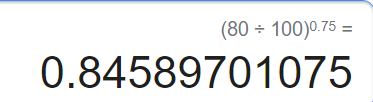

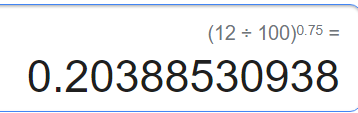

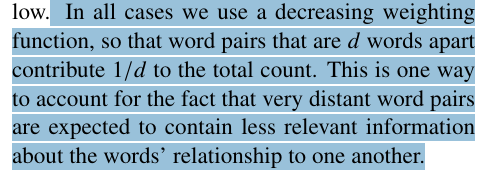

If words 𝑤 𝑖 and 𝑤 𝑗 co-occur in the same context window, how can we use their distance in the text sequence to redesign the method for calculating the conditional probability 𝑝 𝑖 𝑗 ? Hint: see Section 4.2 of the GloVe paper (Pennington et al., 2014).

Với pij = 1/d.
Như hình trên log(pij) = log(1/d) = -log(d)

For any word, are its center word bias and context word bias mathematically equivalent in GloVe? Why?

Đảm bảo tính đối xứng


Trong tiếng Anh, những từ như “helps”, “helped” và “helping” là những dạng biến cách của cùng một từ “help”. Mối quan hệ giữa “chó” và “chó” cũng giống như mối quan hệ giữa “mèo” và “mèo”, và mối quan hệ giữa “cậu bé” và “bạn trai” cũng giống như mối quan hệ giữa “cô gái” và “bạn gái”. Trong các ngôn ngữ khác như tiếng Pháp và tiếng Tây Ban Nha, nhiều động từ có hơn 40 dạng biến cách, trong khi ở Phần Lan, một danh từ có thể có tới 15 trường hợp. Trong ngôn ngữ học, hình thái học nghiên cứu sự hình thành từ và mối quan hệ từ. Tuy nhiên, cấu trúc bên trong của các từ chưa được khám phá trong word2vec cũng như trong GloVe.

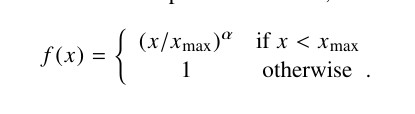

In [ ]:
def h(x_ij):
  x_max = 100
  alpha = 0.75

  if x_ij < x_max:
    return (x_ij/x_max)**alpha
  else:
    return 1

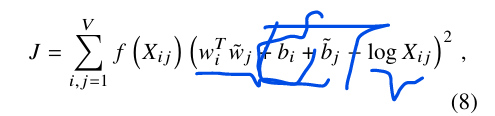

In [ ]:
def glove_loss(center, context, mask, net, X):
    v = net[0](center)
    b = net[1](center)
    u = net[2](context)
    c = net[3](context).squeeze()
    uv = torch.bmm(v, u.permute(0, 2, 1)).squeeze()
    x=np.array(X)
    x_ij= torch.tensor(np.take(x, center * x.shape[1] + context))
    w = x_ij.float().apply_(h)
    logd =torch.log(torch.range(1,context.shape[1])).repeat(context.shape[0],1)
    l=mask*w*(uv+logd+b+c)**2
    return l


In [ ]:
import time
import collections
import math
import os
import random
import torch
import warnings
import sys
import pandas as pd
import torch
import torch.nn as nn
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
warnings.filterwarnings("ignore")


d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

class RandomGenerator:
    """Randomly draw among {1, ..., n} according to n sampling weights."""
    def __init__(self, sampling_weights,k=10000):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0
        self.k = k

    def draw(self):
        if self.i == len(self.candidates):
            # Cache `k` random sampling results
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=self.k)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]


def subsample(sentences, vocab,flag=True):
    """Subsample high-frequency words."""
    # Exclude unknown tokens ('<unk>')
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    counter = collections.Counter([
        token for line in sentences for token in line])
    num_tokens = sum(counter.values())

    # Return True if `token` is kept during subsampling
    def keep(token):
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))
    if flag:
        return ([[token for token in line if keep(token)] for line in sentences],
            counter)
    return (sentences,counter)


def get_centers_and_contexts(corpus, max_window_size,X):
    """Return center words and context words in skip-gram."""
    centers, contexts = [], []
    for line in corpus:
        # To form a "center word--context word" pair, each sentence needs to
        # have at least 2 words
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at `i`
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # Exclude the center word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
            for idx in indices:
                X[line[idx]][line[i]] += 1
                X[line[i]][line[idx]] += 1
    return centers, contexts


def read_ptb():
    """Load the PTB dataset into a list of text lines."""
    data_dir = d2l.download_extract('ptb')
    # Read the training set
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]


def get_negatives(all_contexts, vocab, counter, K, k=10000):
    """Return noise words in negative sampling."""
    # Sampling weights for words with indices 1, 2, ... (index 0 is the
    # excluded unknown token) in the vocabulary
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights,k)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

#
# def batchify(data):
#     """Return a minibatch of examples for skip-gram with negative sampling."""
#     max_len = max(len(c) + len(n) for _, c, n in data)
#     centers, contexts_negatives, masks, labels = [], [], [], []
#     for center, context, negative in data:
#         cur_len = len(context) + len(negative)
#         centers += [center]
#         contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
#         masks += [[1] * cur_len + [0] * (max_len - cur_len)]
#         labels += [[1] * len(context) + [0] * (max_len - len(context))]
#     return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
#         contexts_negatives), torch.tensor(masks), torch.tensor(labels))

def batchify(data):
    """Return a minibatch of examples for skip-gram with negative sampling."""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts,masks = [], [], []
    for center, context, negative in data:
        cur_len = len(context)
        centers += [center]
        contexts += [context + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts), torch.tensor(masks))



def load_data_ptb(batch_size, max_window_size, num_noise_words, flag=True, k=10000):
    """Download the PTB dataset and then load it into memory."""
    # num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab, flag)
    corpus = [vocab[line] for line in subsampled]
    n = len(vocab)
    X = [[0]*n for i in range(n)]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size,X)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words, k=k)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                      collate_fn=batchify)
    return data_iter, vocab,X

def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

class SigmoidBCELoss(nn.Module):
    # Binary cross-entropy loss with masking
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

def weighting(x_ij):
    x_max = 100  # 100 fixed in paper
    alpha = 0.75

    if x_ij < x_max:
        result = (x_ij / x_max)**alpha
    else:
        result = 1

    return result

def glove_loss(center, context, mask, net, X):
    v = net[0](center)
    b = net[1](center)
    u = net[2](context)
    c = net[3](context).squeeze()
    uv = torch.bmm(v, u.permute(0, 2, 1)).squeeze()
    x=np.array(X)
    x_ij= torch.tensor(np.take(x, center * x.shape[1] + context))
    w = x_ij.float().apply_(weighting)
    logd =torch.log(torch.range(1,context.shape[1])).repeat(context.shape[0],1)
    l=mask*w*(uv+logd+b+c)**2
    return l

def train(net, data_iter, X, lr, num_epochs, device='cpu'):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)
    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    # Sum of normalized losses, no. of normalized losses
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context, mask =[
                data.to(device) for data in batch]
            l = glove_loss(center, context, mask, net, X)
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')
    return metric[0] / metric[1]

def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')
data_iter, vocab, X = load_data_ptb(512, 5, 5)
lr, num_epochs = 0.002, 5
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=1),
                    nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=embed_size),
                     nn.Embedding(num_embeddings=len(vocab),
                                 embedding_dim=1),
                    )
train(net, data_iter, X, lr, num_epochs)

Recall how words are represented in word2vec. In both the skip-gram model and the continuous bag-of-words model, different inflected forms of the same word are directly represented by different vectors without shared parameters. To use morphological information, the fastText model proposed a subword embedding approach, where a subword is a character
-gram (Bojanowski et al., 2017). Instead of learning word-level vector representations, fastText can be considered as the subword-level skip-gram, where each center word is represented by the sum of its subword vectors.

Let's illustrate how to obtain subwords for each center word in fastText using the word "where". First, add special characters "<" and ">" at the beginning and end of the word to distinguish prefixes and suffixes from other subwords. Then, extract character 𝑛 -grams from the word. For example, when 𝑛 = 3 , we obtain all subwords of length 3: ""whe", "her", "ere", "re>", and the special subword ""

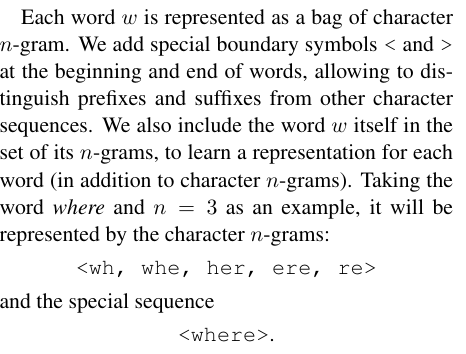

Lưu ý rằng chuỗi '<.her.>', tương ứng với từ her, khác với ba chữ her và từ ở đâu. Trong thực tế, chúng tôi trích xuất tất cả n-gram cho n lớn hơn hoặc bằng 3 và nhỏ hơn hoặc bằng 6. Đây là một cách tiếp cận rất đơn giản và có thể xem xét các tập hợp n-gram khác nhau, chẳng hạn như lấy tất cả các tiền tố và hậu tố.

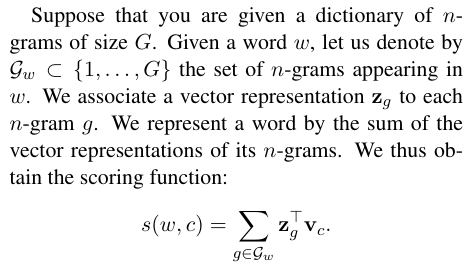

Mô hình đơn giản này cho phép chia sẻ cách biểu diễn giữa các từ, do đó cho phép học cách biểu diễn đáng tin cậy cho các từ hiếm. Để giới hạn các yêu cầu bộ nhớ của mô hình, chúng tôi sử dụng hàm băm để ánh xạ n-gram thành các số nguyên từ 1 đến K. Chúng tôi băm các chuỗi ký tự bằng cách sử dụng hàm băm Fowler-Noll-Vo (cụ thể là biến thể FNV-1a).1 Chúng tôi đặt K = 2106 ở mức thấp. Cuối cùng, một từ được biểu thị bằng chỉ mục của nó trong từ điển từ và tập hợp n-gram băm mà nó chứa.

Dưới đây là bản dịch của nội dung:

Trong fastText, đối với bất kỳ từ nào $ w $, ký hiệu $ G_w $ là tập hợp tất cả các subword của nó có độ dài từ 3 đến 6 ký tự và subword đặc biệt của nó. Từ vựng là tập hợp tất cả các subword của tất cả các từ. Giả sử $ z_g $ là vector của subword $ g $ trong từ điển, vector $ v_w $ cho từ $ w $ với vai trò là từ trung tâm trong mô hình skip-gram được tính bằng tổng các vector subword của nó:

$$ v_w = \sum_{g \in G_w} z_g $$

Phần còn lại của fastText giống với mô hình skip-gram. So với mô hình skip-gram, từ vựng trong fastText lớn hơn, dẫn đến việc có nhiều tham số mô hình hơn. Ngoài ra, để tính toán biểu diễn của một từ, tất cả các vector subword của nó phải được cộng lại, dẫn đến độ phức tạp tính toán cao hơn. Tuy nhiên, nhờ việc chia sẻ tham số từ các subword giữa những từ có cấu trúc tương tự, những từ hiếm gặp và thậm chí cả các từ ngoài từ điển (out-of-vocabulary) có thể có được các vector biểu diễn tốt hơn trong fastText.

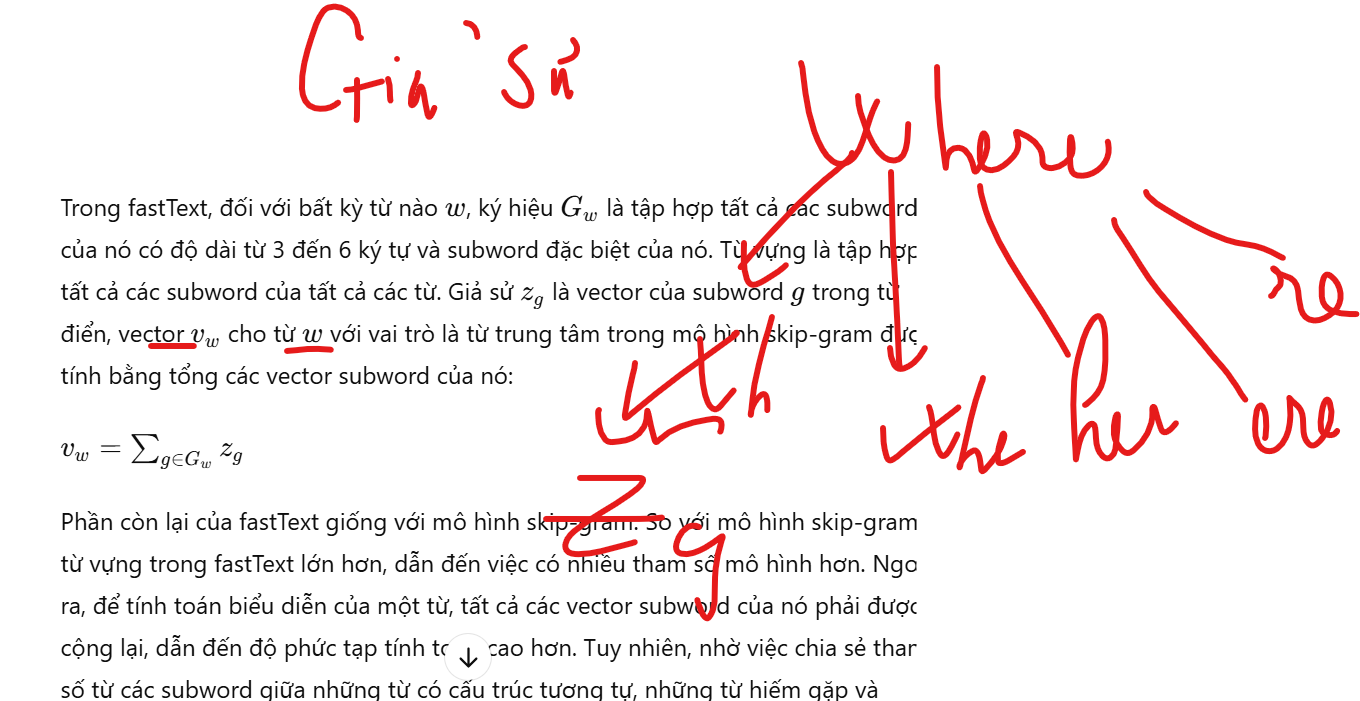

Dưới đây là một ví dụ minh họa cụ thể về cách fastText hoạt động với các **subword**:

Giả sử chúng ta có từ **"cat"**. Trong fastText, từ này sẽ được chia thành các **subword** có độ dài từ 3 đến 6 ký tự. Các **subword** có thể bao gồm:

- 3 ký tự: "cat", "ca", "at"
- 4 ký tự: "cat", "cat_"
- 5 ký tự: "cat__", "ca__", "at__" (với dấu `_` đại diện cho padding)
- 6 ký tự: "cat___", "ca___", "at___"

Ngoài ra, fastText còn có một **subword đặc biệt** cho từ đầy đủ, ví dụ: `<cat>`.

Giả sử vector của các subword này trong từ điển là:

- **"cat"**: \( z_{\text{cat}} = [0.2, 0.3, 0.1] \)
- **"ca"**: \( z_{\text{ca}} = [0.1, 0.2, 0.1] \)
- **"at"**: \( z_{\text{at}} = [0.3, 0.1, 0.2] \)
- **"<cat>"** (subword đặc biệt): \( z_{<\text{cat}>} = [0.5, 0.4, 0.3] \)

Khi đó, để biểu diễn vector của từ **"cat"**, fastText sẽ tính tổng các vector của các subword liên quan:

\[
v_{\text{cat}} = z_{\text{cat}} + z_{\text{ca}} + z_{\text{at}} + z_{<\text{cat}>}
\]

Cụ thể:

\[
v_{\text{cat}} = [0.2, 0.3, 0.1] + [0.1, 0.2, 0.1] + [0.3, 0.1, 0.2] + [0.5, 0.4, 0.3]
\]

Kết quả:

\[
v_{\text{cat}} = [1.1, 1.0, 0.7]
\]

Như vậy, vector của từ **"cat"** là **[1.1, 1.0, 0.7]**.

**Lợi ích của fastText:**
- **Từ hiếm gặp**: Nếu trong văn bản có từ hiếm gặp hoặc thậm chí từ ngoài từ điển (ví dụ như từ **"cats"**), fastText vẫn có thể tạo vector biểu diễn cho từ này bằng cách chia nó thành các subword (ví dụ: "cat" + "s"), từ đó giúp mô hình học được mối quan hệ giữa các từ có cấu trúc tương tự.


xem thêm : https://colab.research.google.com/drive/1mtIJ9ZzN10O7tZjG_RTXGXbPLJZWNW_q#scrollTo=bNwKyry0o6pG

https://arxiv.org/pdf/1508.07909

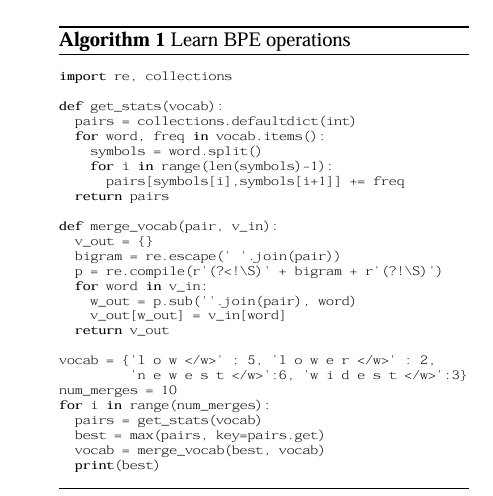

In [ ]:
 import re, collections
 def get_stats(vocab):
    pairs = collections.defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
          pairs[symbols[i],symbols[i+1]] += freq
    return pairs

 def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
      w_out = p.sub(''.join(pair), word)
      v_out[w_out] = v_in[word]
    return v_out
 vocab = {'l o w </w>' : 5, 'l o w e r </w>' : 2,
 'n e w e s t </w>':6, 'w i d e s t </w>':3}
 num_merges = 10
 for i in range(num_merges):
    pairs = get_stats(vocab)
    best = max(pairs, key=pairs.get)
    vocab = merge_vocab(best, vocab)
    print(best)

('e', 's')
('es', 't')
('est', '</w>')
('l', 'o')
('lo', 'w')
('n', 'e')
('ne', 'w')
('new', 'est</w>')
('low', '</w>')
('w', 'i')


Trong fastText, tất cả các từ con được trích xuất phải có độ dài được chỉ định, ví dụ như từ 3 đến 6 ký tự, do đó kích thước từ vựng không thể được xác định trước. Để cho phép các từ con có độ dài thay đổi trong một từ vựng có kích thước cố định, ta có thể áp dụng một thuật toán nén gọi là mã hóa cặp byte (byte pair encoding - BPE) để trích xuất các từ con (Sennrich et al., 2015).

Mã hóa cặp byte thực hiện phân tích thống kê trên tập dữ liệu huấn luyện để phát hiện các ký hiệu phổ biến trong một từ, chẳng hạn như các ký tự liên tiếp có độ dài tùy ý. Bắt đầu với các ký hiệu có độ dài 1, mã hóa cặp byte sẽ lần lượt ghép cặp các ký hiệu liên tiếp xuất hiện thường xuyên nhất để tạo ra các ký hiệu dài hơn. Lưu ý rằng, để đảm bảo hiệu quả, các cặp ký hiệu vượt qua ranh giới từ sẽ không được xem xét. Cuối cùng, ta có thể sử dụng những ký hiệu này làm các từ con để phân đoạn từ. Mã hóa cặp byte và các biến thể của nó đã được sử dụng để biểu diễn đầu vào trong các mô hình huấn luyện phổ biến trong xử lý ngôn ngữ tự nhiên như GPT-2 (Radford et al., 2019) và RoBERTa (Liu et al., 2019).

Dưới đây, chúng tôi sẽ minh họa cách mã hóa cặp byte hoạt động.

Trước tiên, ta khởi tạo từ vựng của các ký hiệu bao gồm tất cả các ký tự viết thường trong tiếng Anh, một ký hiệu đặc biệt cho kết thúc từ '_', và một ký hiệu đặc biệt '[UNK]' cho các từ không xác định.

In [ ]:
import collections

symbols = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
           '_', '[UNK]']

Vì chúng ta không xem xét các cặp ký hiệu vượt qua ranh giới của từ, ta chỉ cần một từ điển `raw_token_freqs` ánh xạ các từ với tần suất xuất hiện của chúng (số lần xuất hiện) trong tập dữ liệu. Lưu ý rằng ký hiệu đặc biệt '_' được thêm vào cuối mỗi từ để dễ dàng khôi phục chuỗi từ (ví dụ: “a taller man”) từ chuỗi các ký hiệu đầu ra (ví dụ: “a_ tall er_ man”). Vì chúng ta bắt đầu quá trình gộp từ một từ vựng chỉ bao gồm các ký tự đơn lẻ và các ký hiệu đặc biệt, dấu cách được chèn giữa mỗi cặp ký tự liên tiếp trong từng từ (các khóa của từ điển `token_freqs`). Nói cách khác, dấu cách là dấu phân cách giữa các ký hiệu trong một từ.

In [ ]:
raw_token_freqs = {'fast_': 4, 'faster_' : 3, 'tall_' : 5, 'taller_':4}
token_freqs = {}
for token, freq in raw_token_freqs.items():
    token_freqs[' '.join(list(token))] = raw_token_freqs[token]
token_freqs

{'f a s t _': 4, 'f a s t e r _': 3, 't a l l _': 5, 't a l l e r _': 4}

In [ ]:
def get_max_freq_pair(token_freqs):
  pairs = collections.defaultdict(int)
  for token, freq in token_freqs.items():
    symbols = token.split()
    for i in range(len(symbols) - 1):
      pairs[symbols[i], symbols[i + 1]] += freq
  return max(pairs, key=pairs.get)  # Key of `pairs` with the max value

In [ ]:
def merge_symbols(max_freq_pair, token_freqs, symbols):
    symbols.append(''.join(max_freq_pair))
    new_token_freqs = dict()
    for token, freq in token_freqs.items():
        new_token = token.replace(' '.join(max_freq_pair),
                                  ''.join(max_freq_pair))
        new_token_freqs[new_token] = token_freqs[token]
    return new_token_freqs

In [ ]:
num_merges = 10
for i in range(num_merges):
    max_freq_pair = get_max_freq_pair(token_freqs)
    token_freqs = merge_symbols(max_freq_pair, token_freqs, symbols)
    print(f'merge #{i + 1}:', max_freq_pair)

merge #1: ('t', 'a')
merge #2: ('ta', 'l')
merge #3: ('tal', 'l')
merge #4: ('f', 'a')
merge #5: ('fa', 's')
merge #6: ('fas', 't')
merge #7: ('e', 'r')
merge #8: ('er', '_')
merge #9: ('tall', '_')
merge #10: ('fast', '_')


In [ ]:
def segment_BPE(tokens, symbols):
    outputs = []
    for token in tokens:
        start, end = 0, len(token)
        cur_output = []
        # Segment token with the longest possible subwords from symbols
        while start < len(token) and start < end:
            if token[start: end] in symbols:
                cur_output.append(token[start: end])
                start = end
                end = len(token)
            else:
                end -= 1
        if start < len(token):
            cur_output.append('[UNK]')
        print(cur_output)
        outputs.append(' '.join(cur_output))
    return outputs

In [ ]:
print(symbols)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[UNK]', 'ta', 'tal', 'tall', 'fa', 'fas', 'fast', 'er', 'er_', 'tall_', 'fast_']


In [ ]:
tokens = ['tallest_', 'fatter_']
print(segment_BPE(tokens, symbols))

['tall', 'e', 's', 't', '_']
['fa', 't', 't', 'er_']
['tall e s t _', 'fa t t er_']


The fastText model proposes a subword embedding approach. Based on the skip-gram model in word2vec, it represents a center word as the sum of its subword vectors. [Mô hình fastText đề xuất cách tiếp cận nhúng từ phụ. Dựa trên mô hình Skip-gram trong word2vec, nó biểu thị một từ trung tâm dưới dạng tổng các vectơ từ phụ của nó.] x

Byte pair encoding performs a statistical analysis of the training dataset to discover common symbols within a word. As a greedy approach, byte pair encoding iteratively merges the most frequent pair of consecutive symbols. [Mã hóa cặp byte thực hiện phân tích thống kê tập dữ liệu huấn luyện để khám phá các ký hiệu phổ biến trong một từ. Là một cách tiếp cận tham lam, mã hóa cặp byte sẽ hợp nhất lặp đi lặp lại cặp ký hiệu liên tiếp thường xuyên nhất.] x

Subword embedding may improve the quality of representations of rare words and out-of-dictionary words. [Việc nhúng từ phụ có thể cải thiện chất lượng biểu diễn các từ hiếm và các từ ngoài từ điển.] x



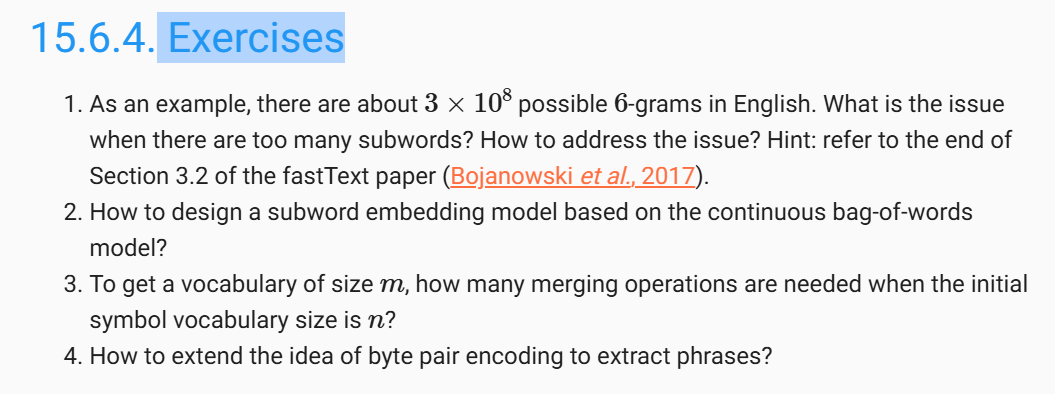

Để giới hạn các yêu cầu bộ nhớ của mô hình, chúng tôi sử dụng hàm băm để ánh xạ n-gram thành các số nguyên từ 1 đến K. Chúng tôi băm các chuỗi ký tự bằng cách sử dụng hàm băm Fowler-Noll-Vo (cụ thể là biến thể FNV-1a).1 Chúng tôi đặt K = 2106 ở mức thấp. Cuối cùng, một từ được biểu thị bằng chỉ mục của nó trong từ điển từ và tập hợp n-gram băm mà nó chứa.

2. Làm cách nào để thiết kế mô hình nhúng subword dựa trên mô hình túi từ liên tục?

Define a CBOW model that takes a sequence of context subwords as input, and outputs a probability distribution over the target subwords

Tức là lấy các subword cho các inputs =>  target subwords
3. Để có được từ vựng có kích thước 𝑚 , cần bao nhiêu thao tác hợp nhất khi kích thước từ vựng ký hiệu ban đầu là 𝑛 ?

m/n
4. Làm cách nào để mở rộng ý tưởng mã hóa cặp byte để trích xuất các cụm từ?
How to extend the idea of byte pair encoding to extract phrases?
To extend the idea of BPE to extract phrases, one possible approach is to apply BPE on the word level, rather than the character level. That is, instead of treating each character as a symbol, we can treat each word as a symbol, and merge the most frequent pair of words into a new phrase. This way, we can obtain a vocabulary of phrases that capture the collocations and idioms of the language.

## Bidirectional Encoder Representations from Transformers (BERT)

### From Context-Independent to Context-Sensitive

Điều này thúc đẩy sự phát triển của cách biểu diễn từ theo ngữ cảnh, trong đó cách biểu diễn từ phụ thuộc vào ngữ cảnh của chúng. Do đó, cách biểu diễn mã thông báo 𝑥 theo ngữ cảnh là một hàm 𝑓 ( 𝑥 , 𝑐 ( 𝑥 ) ) tùy thuộc vào cả 𝑥 và ngữ cảnh của nó 𝑐 ( 𝑥 ) . Các cách biểu diễn phù hợp với ngữ cảnh phổ biến bao gồm TagLM (trình gắn thẻ trình tự tăng cường mô hình ngôn ngữ) (Peters và cộng sự, 2017), CoVe (Vectơ bối cảnh) (McCann và cộng sự, 2017) và ELMo (Nhúng từ mô hình ngôn ngữ) (Peters et al. cộng sự, 2018).

#### Languagemodel augmented sequence taggers (TagLM)


https://arxiv.org/pdf/1705.00108

 Languagemodel augmented sequence
 taggers (TagLM)

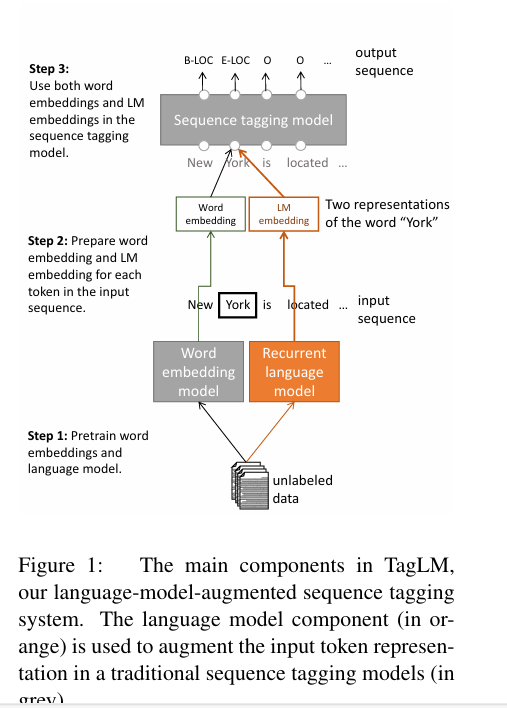

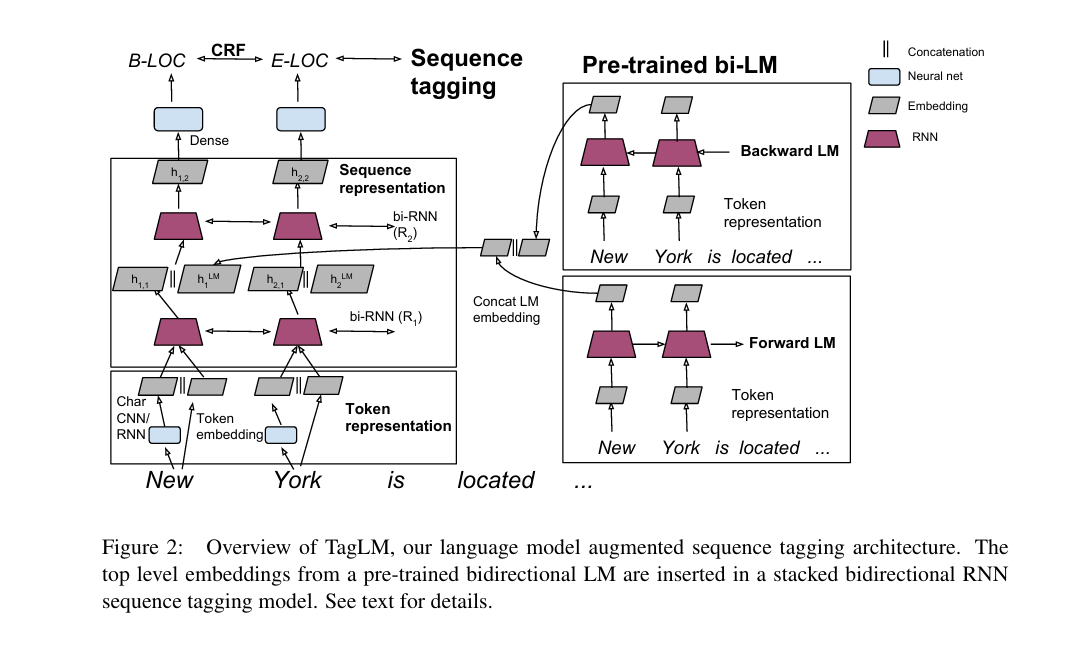

mehttps://medium.com/@sh-tsang/review-semi-supervised-sequence-tagging-with-bidirectional-language-models-taglm-15485e98d15

#### CoVe (Context Vectors)

Replacing your Word Embeddings by Contextualized Word Vectors

https://sh-tsang.medium.com/review-learned-in-translation-contextualized-word-vectors-cove-ac3d3ab28c5b

https://arxiv.org/pdf/1708.00107

Nó lấy cảm hứng từ MT encoder và decoder, việc huấn luyện MT, rồi sau đó lấy các trọng số đầu ra của encoder để thực hiện các tác vụ khác, đầu vào sẽ là context vectors (có thể glove và word2vec)

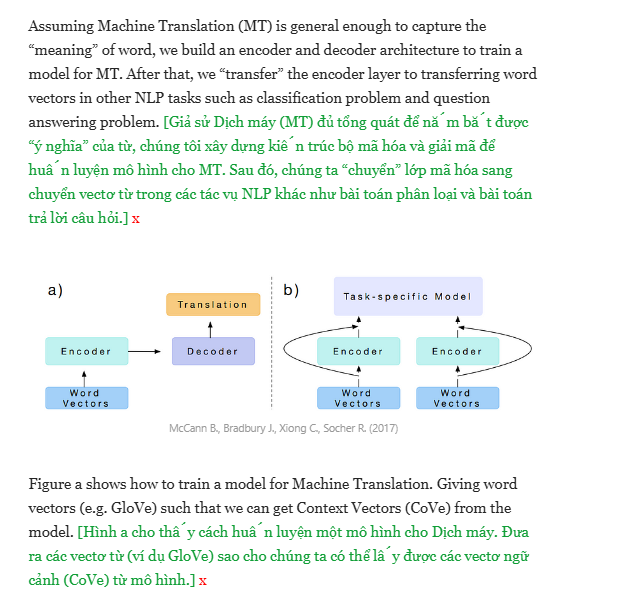

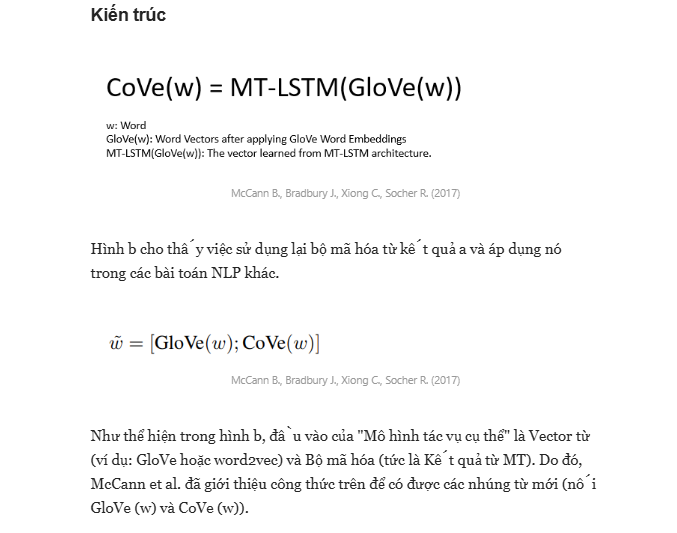

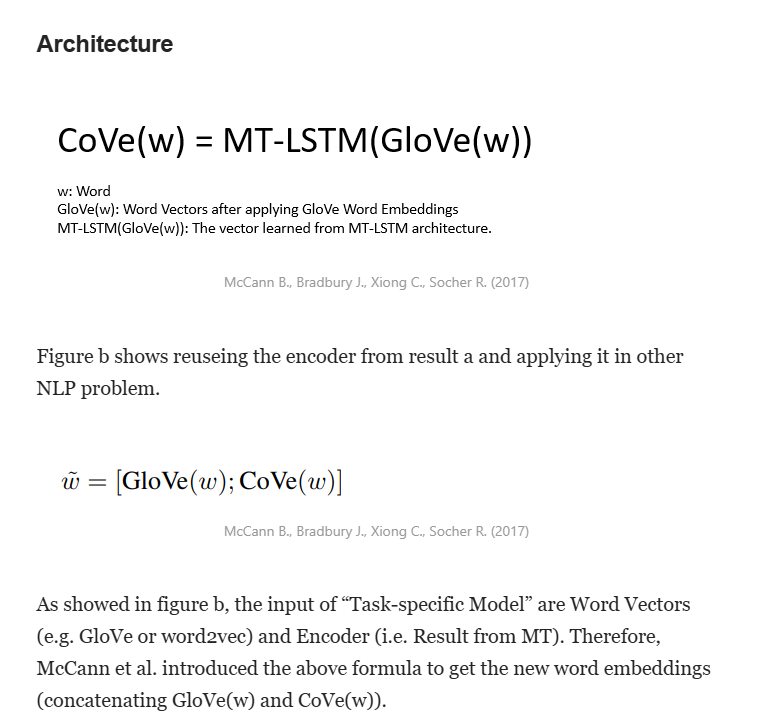

chttps://readmedium.com/replacing-your-word-embeddings-by-contextualized-word-vectors-9508877ad65d

Code :

https://github.com/rgsachin/CoVe

#### ELMo (Embeddings from Language Models).

Khác với cách nhúng từ truyền thống, ELMo tạo ra nhiều cách nhúng từ cho mỗi từ duy nhất cho các tình huống khác nhau. **Các lớp cấp cao hơn nắm bắt các khía cạnh phụ thuộc vào ngữ cảnh của việc nhúng từ** trong khi **các lớp cấp thấp hơn nắm bắt các khía cạnh mô hình của cú pháp**. Trong trường hợp đơn giản nhất, chúng ta chỉ sử dụng lớp trên cùng (chỉ 1 lớp) từ ELMo trong khi chúng ta cũng có thể kết hợp tất cả các lớp thành một vectơ duy nhất.

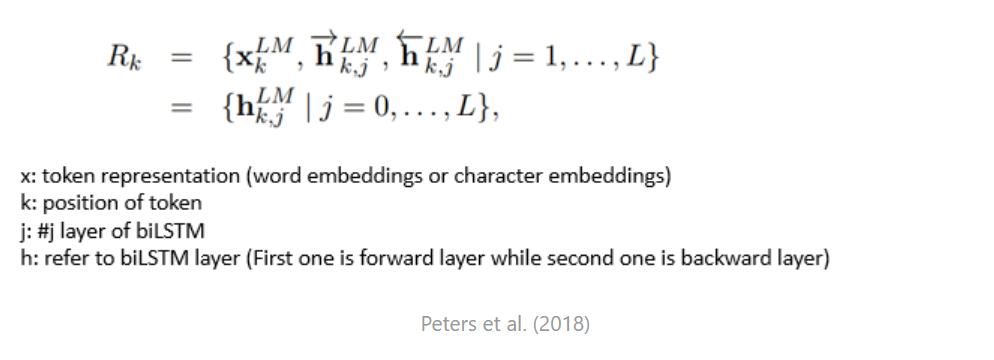

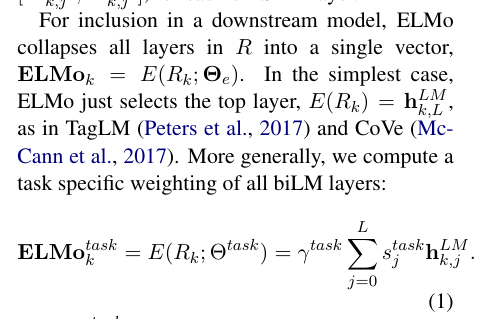

Khác với TagLM, CoVe sử dụng một biểu thức (1)

Trong (1), $𝑠 ____(𝑡𝑎𝑠𝑘)$ là các trọng số được chuẩn hóa bằng softmax,$gama$ và tham số vô hướng $gama$ cho phép mô hình tác vụ điều chỉnh toàn bộ vector ELMo. Điều này có ý nghĩa thực tiễn trong việc hỗ trợ quá trình tối ưu hóa (xem tài liệu bổ sung để biết thêm chi tiết).

Xem xét rằng các kích hoạt của mỗi lớp biLM có phân phối khác nhau, trong một số trường hợp, việc áp dụng chuẩn hóa lớp (layer normalization) cho mỗi lớp biLM trước khi trọng số cũng giúp cải thiện hiệu suất.

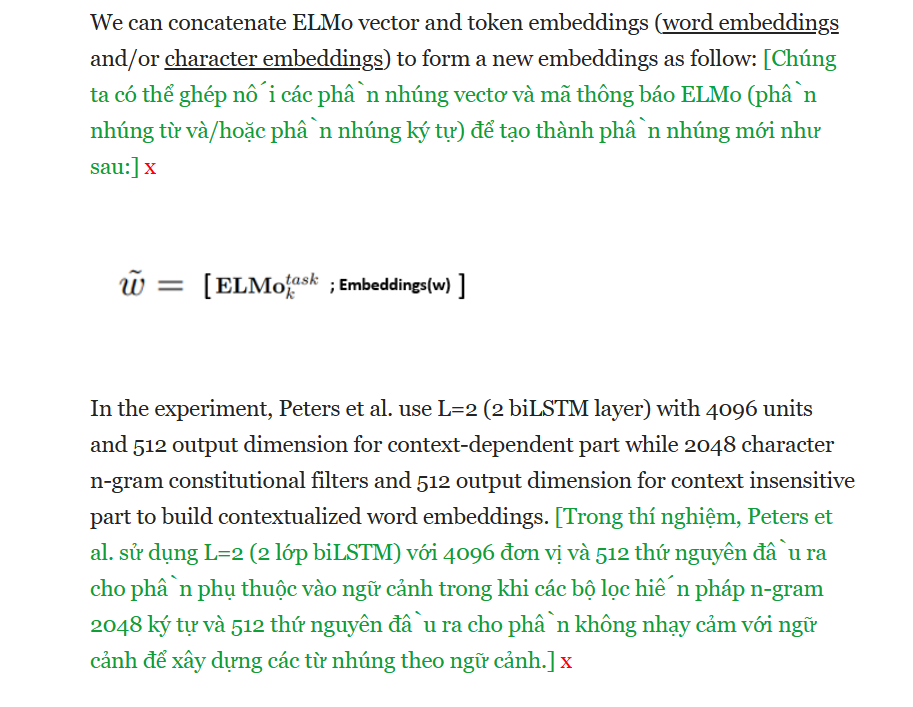

code :

CoVe needs label data to get the contextual word vectors while ELMo go for unsupervised way. [Cove cần dữ liệu nhãn để lấy vectơ từ theo ngữ cảnh trong khi ELMo thực hiện theo cách không giám sát.] x

CoVe use only the last layer while ELMo use multiple layer for contextual word representations. [Cove chỉ sử dụng lớp cuối cùng trong khi ELMo sử dụng nhiều lớp để biểu diễn từ theo ngữ cảnh.] x

CoVe unable to resolve OOV issue. It suggests to use zero vectors to represent unknown word. ELMO can handle the OOV problem as it uses character embeddings to build word embeddings. [Cove không thể giải quyết vấn đề OOV. Nó gợi ý sử dụng vectơ 0 để biểu thị từ chưa biết. ELMO có thể xử lý vấn đề OOV vì nó sử dụng các phần nhúng ký tự để xây dựng các phần nhúng từ.] x

ELMo is quite time consuming to compute vectors. Per authors suggested, you can precompute token offline and lookup it during online prediction to reduce time spending. [ELMo tốn khá nhiều thời gian để tính toán vectơ. Theo đề xuất của tác giả, bạn có thể tính toán trước mã thông báo ngoại tuyến và tra cứu mã thông báo đó trong quá trình dự đoán trực tuyến để giảm thời gian chi tiêu.]

Vấn đề OOV (Out of Vocabulary) đề cập đến những từ hoặc cụm từ không có trong từ điển hoặc danh sách từ vựng mà mô hình xử lý ngôn ngữ (NLP) đã được đào tạo. Vấn đề này thường xảy ra khi:

Từ mới: Một từ mới xuất hiện trong dữ liệu đầu vào mà không có trong tập từ vựng mà mô hình đã học.

Sai chính tả: Người dùng nhập từ với sai chính tả hoặc cách viết không chính xác.

Ngôn ngữ chuyên ngành: Từ hoặc cụm từ trong lĩnh vực chuyên ngành mà mô hình không được đào tạo.

xem thêm code : https://github.com/makcedward/nlp/blob/master/sample/nlp-embeddings-sentence-elmo.ipynb

### From Task-Specific to Task-Agnostic

GPT

GPT (Generative Pre-Training) là một mô hình ngôn ngữ tổng quát không phụ thuộc vào tác vụ cụ thể, được thiết kế để biểu diễn các văn bản ngữ cảnh nhạy cảm. Mô hình này được xây dựng trên Transformer decoder và được tiền huấn luyện bằng cách dự đoán chuỗi ngôn ngữ. Khi áp dụng vào các tác vụ hạ nguồn (downstream tasks) , GPT sẽ tinh chỉnh (fine-tune) toàn bộ tham số, thay vì đóng băng như ELMo. GPT đã cải thiện hiệu suất trên nhiều tác vụ ngôn ngữ tự nhiên như suy luận, trả lời câu hỏi và phân loại. Tuy nhiên, do tính chất autoregressive, GPT chỉ nhìn từ trái sang phải, nên không thể nắm bắt hoàn toàn ngữ cảnh hai chiều, dẫn đến vấn đề với từ đa nghĩa trong các ngữ cảnh khác nhau.


###  BERT: Combining the Best of Both Worlds

BERT (Bidirectional Encoder Representations from Transformers) kết hợp những điểm mạnh của ELMo và GPT bằng cách mã hóa ngữ cảnh hai chiều và không phụ thuộc vào kiến trúc tác vụ cụ thể. BERT sử dụng Transformer encoder được tiền huấn luyện để biểu diễn các token dựa trên ngữ cảnh hai chiều. Khi áp dụng vào các tác vụ hạ nguồn, BERT tinh chỉnh toàn bộ tham số giống như GPT, với ít thay đổi trong kiến trúc mô hình. BERT đã cải thiện đáng kể hiệu suất trên 11 tác vụ ngôn ngữ tự nhiên, bao gồm phân loại văn bản đơn, phân loại cặp văn bản, trả lời câu hỏi, và gắn thẻ văn bản.

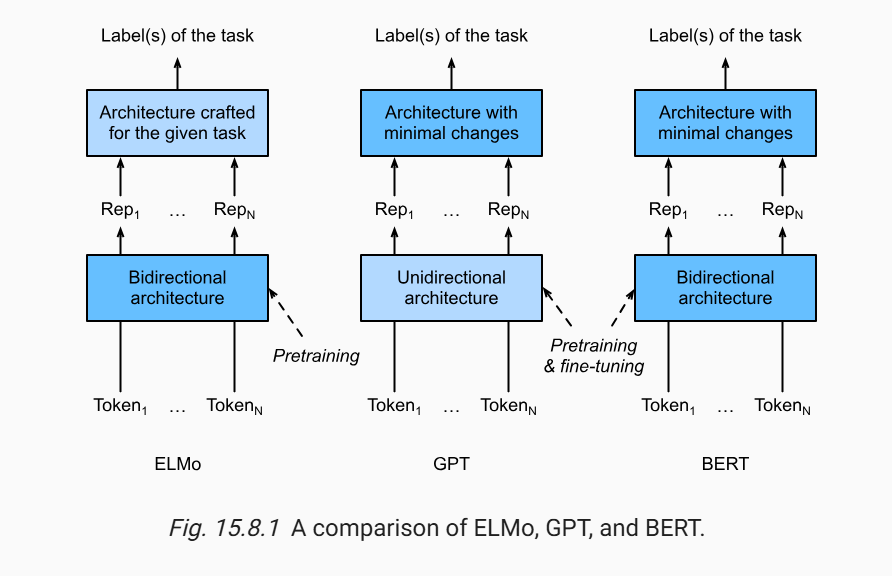

### Input Representation

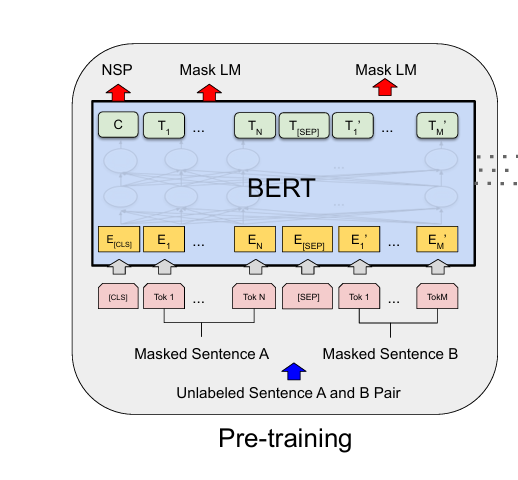

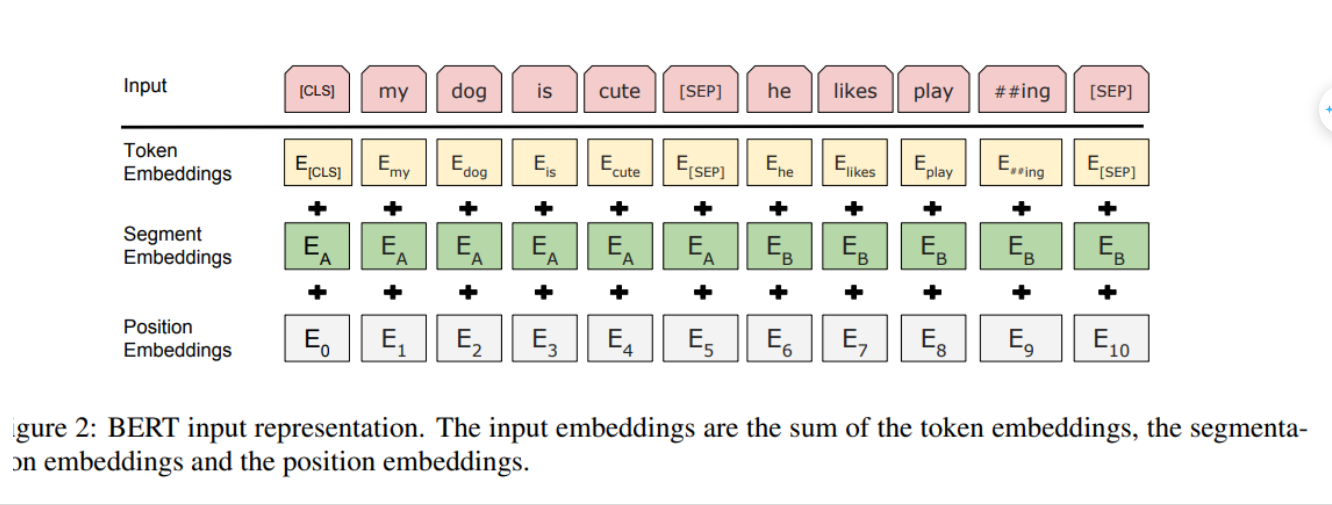

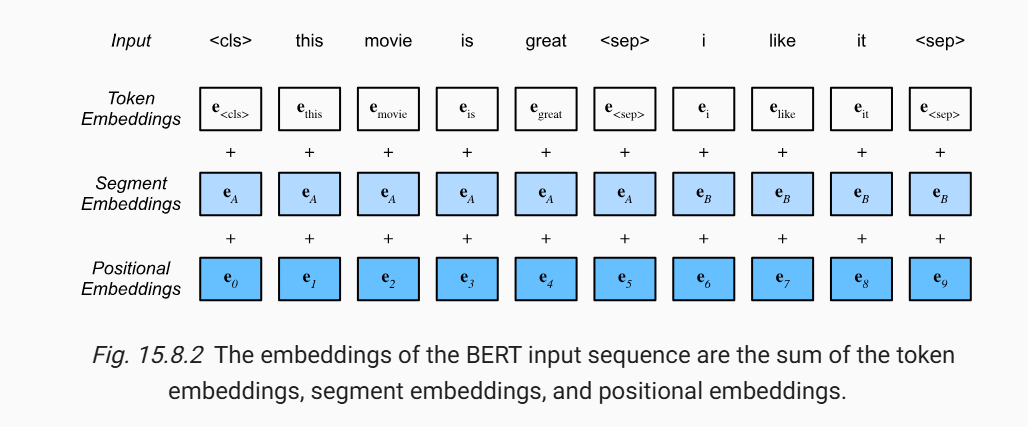

Trong xử lý ngôn ngữ tự nhiên, một số tác vụ (như phân tích cảm xúc) sử dụng văn bản đơn làm đầu vào, trong khi các tác vụ khác (như suy luận ngôn ngữ tự nhiên) sử dụng cặp văn bản. Chuỗi đầu vào của BERT có thể đại diện cho cả văn bản đơn và cặp văn bản. Với văn bản đơn, chuỗi đầu vào là sự kết hợp của token đặc biệt `[CLS]`, các token của văn bản và token `[SEP]`. Với cặp văn bản, chuỗi đầu vào bao gồm `[CLS]`, các token của văn bản thứ nhất, `[SEP]`, các token của văn bản thứ hai, và `[SEP]`. Để phân biệt cặp văn bản, các embeddings đoạn (segment embeddings) 𝑒𝐴 và 𝑒𝐵 được thêm vào các embeddings token của văn bản thứ nhất và thứ hai tương ứng.

Trong BERT, `CLS` viết tắt của "Classification." Token `[CLS]` là một token đặc biệt được thêm vào đầu mỗi chuỗi đầu vào trong BERT. Nó được sử dụng để tổng hợp thông tin từ toàn bộ chuỗi và thường được sử dụng trong các tác vụ phân loại, như phân tích cảm xúc hoặc suy luận ngôn ngữ tự nhiên. Sau khi BERT xử lý chuỗi, embedding của token `[CLS]` chứa thông tin đại diện cho toàn bộ chuỗi và thường được đưa vào tầng cuối để dự đoán nhãn cho tác vụ hạ nguồn.

Hình ảnh này mô tả quy trình pre-training (huấn luyện trước) và fine-tuning (tinh chỉnh) của mô hình BERT. Trong đó, token `[CLS]` đóng vai trò đặc biệt quan trọng:

1. **[CLS] token**:
   - Đây là một token đặc biệt được thêm vào đầu mỗi chuỗi đầu vào (cả trong pre-training lẫn fine-tuning).
   - Mục đích của nó là đại diện cho toàn bộ chuỗi và thường được sử dụng để thực hiện các tác vụ phân loại. Giá trị ẩn của token `[CLS]` sau cùng sẽ là đầu vào cho một lớp softmax để dự đoán nhãn của toàn bộ chuỗi.
   
2. **Pre-training**:
   - Trong giai đoạn này, `[CLS]` được sử dụng cho bài toán Next Sentence Prediction (NSP), nhằm xác định xem hai câu có liên quan với nhau không.
   - Trong Masked Language Modeling (MLM), token này giúp BERT học cách dự đoán từ bị che trong câu.

3. **Fine-tuning**:
   - Trong các tác vụ như phân loại (MNLI) hoặc trích xuất thông tin (NER, SQuAD), token `[CLS]` tiếp tục đóng vai trò như một đại diện tổng thể cho chuỗi để dự đoán kết quả của bài toán cụ thể (ví dụ: câu trả lời hoặc nhãn phân loại).

Tóm lại, `[CLS]` là một token duy nhất, được sử dụng trong các lớp đầu ra của BERT để thực hiện các nhiệm vụ phân loại hay dự đoán trên toàn bộ chuỗi.

Theo "paper Bert" in fine tuning  the [CLS] representation is fed
 into an output layer for classification, such as en
tailment or sentiment analysis.

In [ ]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
  tokens = ['<cls>'] + tokens_a + ['<sep>']
  # 0 and 1 are marking segments A and B, respectively
  segments = [0]*(len(tokens_a) + 2)
  if tokens_b is not None:
    tokens = tokens + tokens_b + ['<sep>']
    segments = segments + [1]*(len(tokens_b)+1)
  return tokens, segments


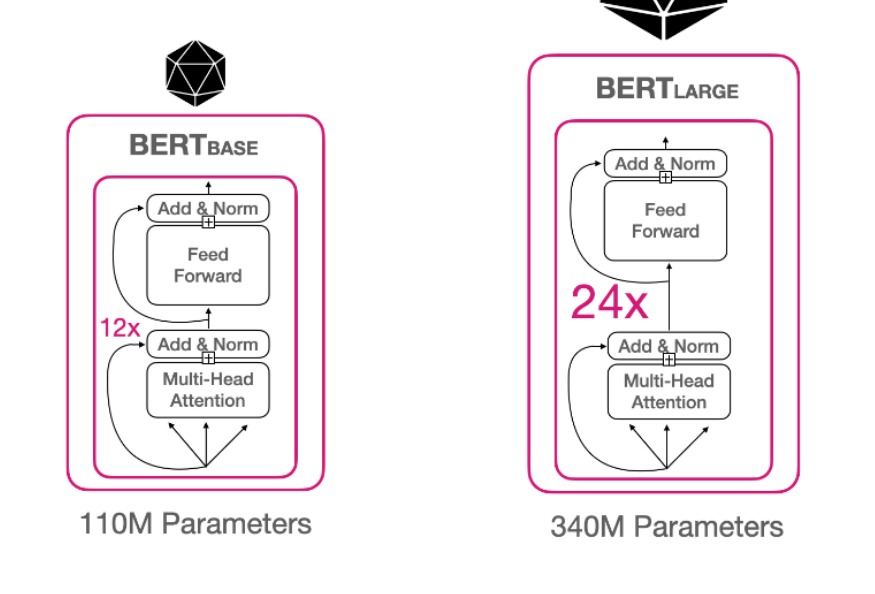

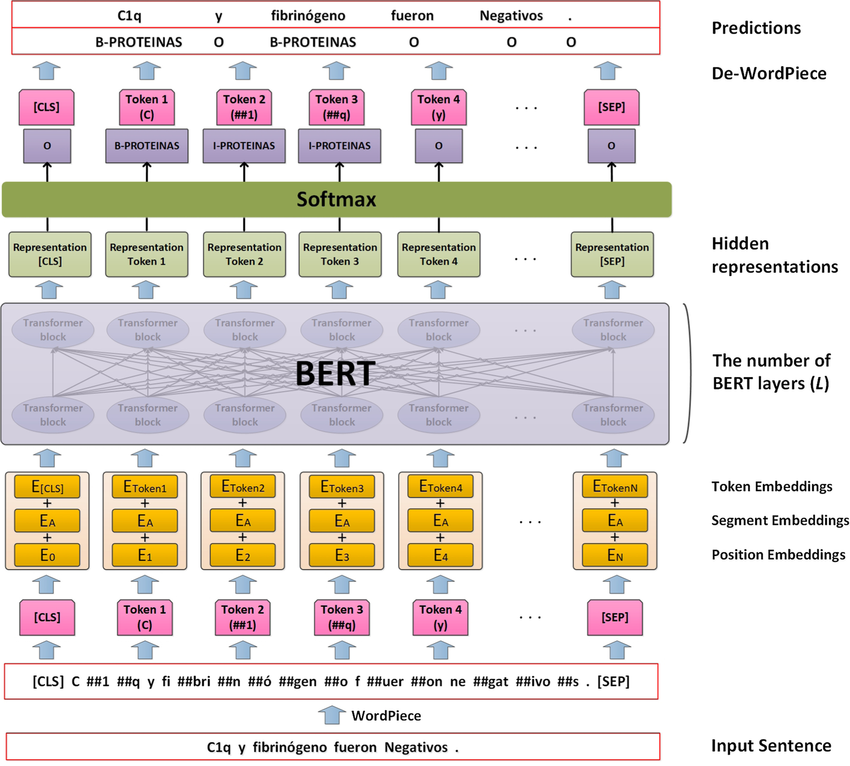

In [ ]:
import torch
from torch import nn

In [ ]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.3 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 9.2 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uni

In [ ]:
from d2l import torch as d2l

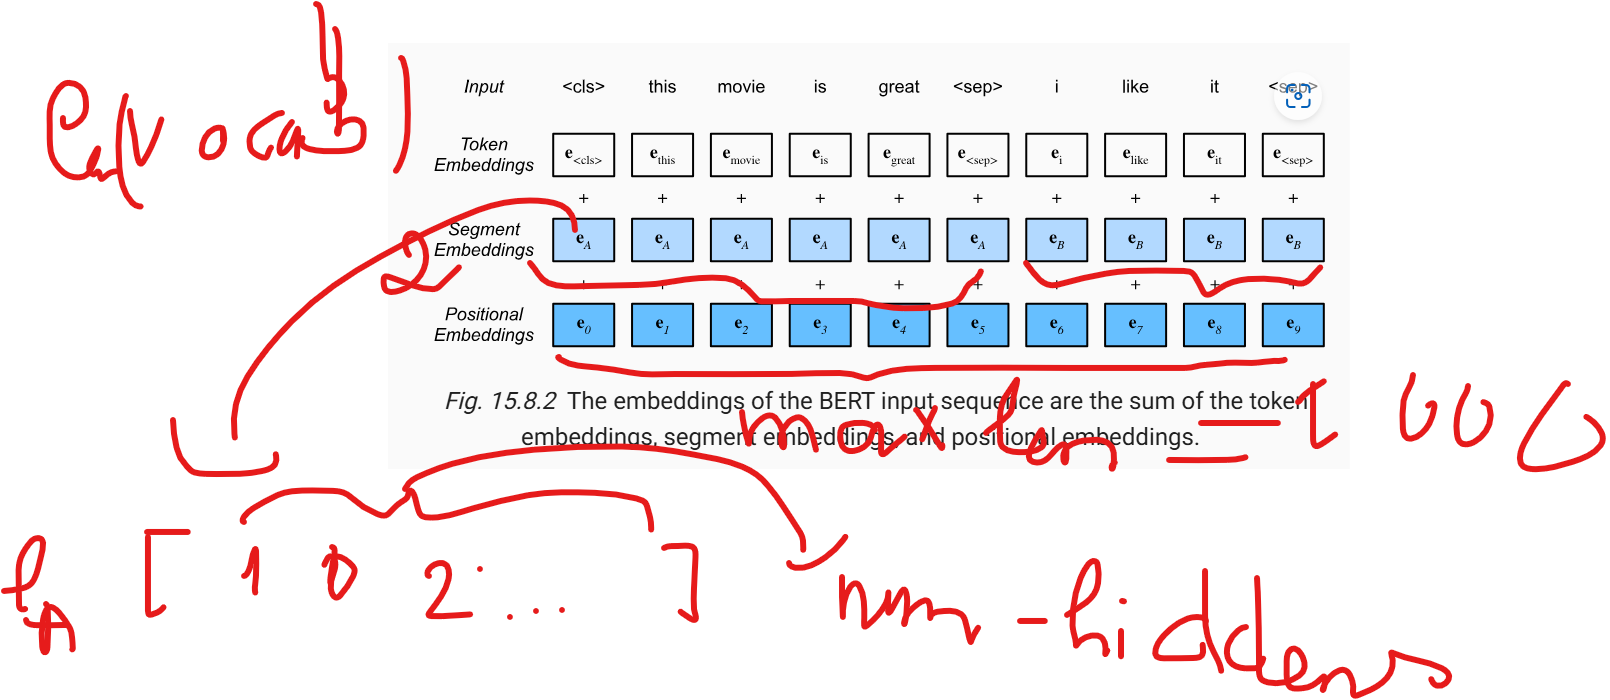

In [ ]:
class BERTEncoder(nn.Module):
  def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout, max_len=1000, **kwargs):
    super(BERTEncoder, self).__init__(**kwargs)
    self.token_embedding = nn.Embedding(vocab_size, num_hiddens) # input vocab_size, output num_hiddens
    # in Bert divide 2 part e A and e B
    self.segment_embedding = nn.Embedding(2, num_hiddens)
    self.blks = nn.Sequential()

    for i in range(num_blks):
      self.blks.add_module(f'{i}', d2l.TransformerEncoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout, True))

    self.pos_embedding = nn.Parameter(torch.randn(1, max_len, num_hiddens))
  def forward(self, tokens, segments, valid_lens):
    X = self.token_embedding(tokens) + self.segment_embedding(segments)
    X = X + self.pos_embedding.data[:, :X.shape[1], :]
    for blk in self.blks:
      X = blk(X, valid_lens) # valid_lens acctual is 5, but its will is 10 if have padding or specific tokens
    return X

In [ ]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
ffn_num_input, num_blks, dropout = 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                      num_blks, dropout)

In [ ]:
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

torch.Size([2, 8, 768])

### Pretraining Tasks

#### Masked Language Modeling


Như được minh họa trong phần 9.3, một mô hình ngôn ngữ dự đoán một token bằng cách sử dụng ngữ cảnh bên trái của nó. Để mã hóa ngữ cảnh theo chiều hai chiều cho việc đại diện cho mỗi token, BERT ngẫu nhiên che dấu các token và sử dụng các token từ ngữ cảnh hai chiều để dự đoán các token bị che dấu theo cách tự giám sát. Nhiệm vụ này được gọi là mô hình ngôn ngữ che dấu.

Trong nhiệm vụ tiền huấn luyện này, 15% các token sẽ được chọn ngẫu nhiên làm các token bị che dấu để dự đoán. Để dự đoán một token bị che dấu mà không gian lận bằng cách sử dụng nhãn, một cách tiếp cận đơn giản là luôn thay thế nó bằng một token đặc biệt "<mask>" trong chuỗi đầu vào BERT. Tuy nhiên, token đặc biệt nhân tạo "<mask>" sẽ không bao giờ xuất hiện trong quá trình tinh chỉnh. Để tránh sự không phù hợp giữa tiền huấn luyện và tinh chỉnh, nếu một token bị che dấu để dự đoán (ví dụ: "great" được chọn để che dấu và dự đoán trong câu "this movie is great"), trong đầu vào, nó sẽ được thay thế bằng:

- một token đặc biệt "<mask>" trong 80% thời gian (ví dụ: "this movie is great" trở thành "this movie is <mask>");
- một token ngẫu nhiên trong 10% thời gian (ví dụ: "this movie is great" trở thành "this movie is drink");
- token nhãn không thay đổi trong 10% thời gian (ví dụ: "this movie is great" trở thành "this movie is great").

Lưu ý rằng trong 10% của 15% thời gian, một token ngẫu nhiên được chèn vào. Sự nhiễu ngẫu nhiên này khuyến khích BERT ít thiên lệch hơn về token bị che dấu (đặc biệt khi token nhãn vẫn không thay đổi) trong việc mã hóa ngữ cảnh hai chiều của nó.

Chúng tôi thực hiện lớp MaskLM sau đây để dự đoán các token bị che dấu trong nhiệm vụ mô hình ngôn ngữ che dấu của quá trình tiền huấn luyện BERT. Việc dự đoán sử dụng một MLP với một lớp ẩn (self.mlp). Trong quá trình suy diễn phía trước, nó nhận hai đầu vào: kết quả mã hóa của BERTEncoder và các vị trí token cần dự đoán. Đầu ra là kết quả dự đoán tại các vị trí này.


tức là 15% tokens bị che dấu

Ví dụ this movie is great

chọn great là từ cần được [mask]

tuy nhiên việc này ảnh hưởng đến quá trình fine tuning. Vì vậy việc chịa nó thành 3 trường hợp trong 15%, giả sử đối với số lần được tokens được [mask] là 100%, 3 trường hợp đó được chia thành như sau:

a special “<mask>” token for 80% of the time (e.g., “this movie is great” becomes “this movie is <mask>”);

a random token for 10% of the time (e.g., “this movie is great” becomes “this movie is drink”);

the unchanged label token for 10% of the time (e.g., “this movie is great” becomes “this movie is great”).



Lưu ý rằng, trong 10% của 15% thời gian, một token ngẫu nhiên được chèn vào. Tiếng ồn ngẫu nhiên này khuyến khích BERT ít thiên vị hơn đối với token bị che (đặc biệt khi token vẫn không thay đổi) trong việc mã hóa ngữ cảnh hai chiều của nó.

In [ ]:
class MaskLM(nn.Module):
    """The masked language model task of BERT."""
    def __init__(self, vocab_size, num_hiddens, **kwargs):
        super(MaskLM, self).__init__(**kwargs)

        # A simple MLP (Multi-Layer Perceptron) consisting of two LazyLinear layers:
        # - First layer: projects the input to 'num_hiddens' dimensions, followed by a ReLU activation
        # - LayerNorm for normalization
        # - Second layer: projects the hidden states to 'vocab_size' (used to predict token vocabulary logits)
        self.mlp = nn.Sequential(
            nn.LazyLinear(num_hiddens),  # LazyLinear initializes the weights when input size is known
            nn.ReLU(),                   # ReLU activation function
            nn.LayerNorm(num_hiddens),    # Layer Normalization to normalize across the features
            nn.LazyLinear(vocab_size)     # Output layer for predictions (logits for each token in vocabulary)
        ) # vocab_size là kích thước của từ điển

    def forward(self, X, pred_positions):
        """
        X: The input tensor (batch_size, seq_length, embedding_dim), where seq_length is the length of the sequence
        and embedding_dim is the dimension of the token embeddings.

        pred_positions: Tensor of shape (batch_size, num_pred_positions), where num_pred_positions is the number of
        masked tokens per sequence that we want to predict.
        """
        # Get the number of predicted positions per sequence
        num_pred_positions = pred_positions.shape[1]

        # Flatten the pred_positions to a 1D tensor for easier indexing
        pred_positions = pred_positions.reshape(-1)

        # Get the batch size from the input X
        batch_size = X.shape[0]

        # Create a tensor representing the batch index, i.e., a sequence of batch indices repeated for each predicted position
        # Example: If batch_size = 2 and num_pred_positions = 3, batch_idx will be [0, 0, 0, 1, 1, 1]
        batch_idx = torch.arange(0, batch_size)
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)

        # Masked X: Extract the token embeddings at the positions to predict (masked tokens)
        # For each batch and its corresponding predicted positions, we extract the embeddings from X.
        # X is indexed by [batch_idx, pred_positions] to get the masked tokens.
        masked_X = X[batch_idx, pred_positions]

        # Reshape the masked tokens to have shape (batch_size, num_pred_positions, embedding_dim)
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))

        # Pass the masked token embeddings through the MLP to get the predictions (logits for each token in the vocabulary)
        mlm_Y_hat = self.mlp(masked_X)

        # Return the predictions for the masked tokens
        return mlm_Y_hat


In [ ]:
encoded_X.shape

torch.Size([2, 8, 768])

In [ ]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

In [ ]:
mlm_Y_hat

tensor([[[ 0.4076,  0.4015, -0.0665,  ..., -0.3192,  1.2262,  0.4518],
         [ 0.9033,  0.2348,  0.7838,  ...,  0.3464,  0.9415,  0.4760],
         [ 0.7047, -0.4150,  0.8682,  ...,  0.0859,  0.1588,  0.3350]],

        [[ 0.9212,  0.2021,  0.8683,  ...,  0.3621,  0.8588,  0.4931],
         [ 0.8684,  0.2533,  0.7094,  ...,  0.3311,  1.0043,  0.4451],
         [ 0.6194,  0.3971,  0.3200,  ...,  0.2128,  1.1774,  0.4013]]],
       grad_fn=<ViewBackward0>)

In [ ]:
mlm_Y = torch.tensor([[7, 10, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape

torch.Size([6])

Để trực quan hóa dữ liệu với đầu vào `encoded_X` và `mlm_positions`, ta cần hiểu rõ cách mà các tensor tương tác với nhau.

Giải thích các bước:

1. **Tạo tokens và segments:**
   ```python
   tokens = torch.randint(0, vocab_size, (2, 8))
   segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
   ```
   - **`tokens`**: Tạo ngẫu nhiên các token từ từ điển với kích thước `(2, 8)`, tức là 2 câu với mỗi câu có 8 token.
   - **`segments`**: Chỉ định phần nào của câu thuộc về phân đoạn nào. Ví dụ: trong câu thứ nhất, các token đầu tiên thuộc đoạn 0 và các token sau thuộc đoạn 1.

2. **Tạo `encoded_X` thông qua encoder:**
   ```python
   encoded_X = encoder(tokens, segments, None)
   ```
   - **`encoded_X`**: Biểu diễn đầu ra của encoder với kích thước `(batch_size, seq_length, embedding_dim)`, trong đó:
     - **`batch_size = 2`**: Có 2 câu.
     - **`seq_length = 8`**: Mỗi câu có 8 token.
     - **`embedding_dim`**: Kích thước embedding mà encoder trả về.

3. **Khởi tạo mô hình `MaskLM` và xác định các vị trí cần dự đoán:**
   ```python
   mlm = MaskLM(vocab_size, num_hiddens)
   mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
   ```
   - **`mlm_positions`**: Xác định các vị trí token bị ẩn trong mỗi câu để dự đoán. Kích thước là `(2, 3)`, tức là:
     - Câu đầu tiên: các vị trí 1, 5, 2 cần được dự đoán.
     - Câu thứ hai: các vị trí 6, 1, 5 cần được dự đoán.

4. **Dự đoán các token bị ẩn (`mlm_Y_hat`):**
   ```python
   mlm_Y_hat = mlm(encoded_X, mlm_positions)
   ```
   - **`encoded_X`** và **`mlm_positions`** được đưa vào mô hình `MaskLM` để dự đoán các token bị ẩn tại các vị trí đã xác định.

Trực quan hóa dữ liệu với đầu vào `encoded_X` và `mlm_positions`:

 Dữ liệu đầu vào:
- **`encoded_X.shape = (2, 8, embedding_dim)`**: Đây là tensor 3 chiều, với 2 câu, mỗi câu có 8 token, và mỗi token được biểu diễn bằng một vector có kích thước `embedding_dim`.
- **`mlm_positions = [[1, 5, 2], [6, 1, 5]]`**: Đối với câu đầu tiên, mô hình sẽ dự đoán các từ tại vị trí 1, 5, 2. Đối với câu thứ hai, mô hình sẽ dự đoán các từ tại vị trí 6, 1, 5.

Sau khi dự đoán:
- **`mlm_Y_hat.shape = (2, 3, vocab_size)`**: Kích thước đầu ra là 3 chiều:
  - **`batch_size = 2`**: Kết quả cho 2 câu.
  - **`3`**: Mỗi câu cần dự đoán 3 từ (vì mỗi câu có 3 vị trí bị ẩn).
  - **`vocab_size`**: Mỗi từ được biểu diễn bởi một vector kích thước `vocab_size` chứa xác suất dự đoán cho mỗi từ trong từ điển.

Trực quan:
1. **`encoded_X`** chứa các embedding cho từng từ trong câu (kích thước `(2, 8, embedding_dim)`).
2. **`mlm_positions`** chỉ ra rằng ta sẽ lấy các embedding ở các vị trí tương ứng để dự đoán.
3. **`mlm_Y_hat`** là kết quả dự đoán cho các từ bị ẩn tại các vị trí đó, với đầu ra là xác suất cho từng từ trong từ điển (kích thước `(2, 3, vocab_size)`).



#### Next Sentence Prediction

Mặc dù mô hình hóa ngôn ngữ có mặt nạ (masked language modeling) trong BERT có thể mã hóa ngữ cảnh hai chiều, nhưng nó không mô hình hóa mối quan hệ logic giữa các cặp văn bản. Để khắc phục điều này, BERT sử dụng một nhiệm vụ phân loại nhị phân gọi là dự đoán câu tiếp theo (next sentence prediction) trong quá trình huấn luyện. Trong nhiệm vụ này, một nửa số cặp câu là các câu liên tiếp với nhãn “Đúng”, trong khi nửa còn lại là các câu ngẫu nhiên với nhãn “Sai”.

Lớp NextSentencePred sử dụng một mạng nơ-ron đa lớp với một lớp ẩn để dự đoán mối quan hệ giữa hai câu. Nhờ cơ chế tự chú ý trong Transformer, biểu diễn của token “<cls>” mã hóa cả hai câu. Lớp đầu ra của bộ phân loại MLP sử dụng đầu ra từ lớp ẩn, nhận đầu vào là biểu diễn của token “<cls>”.

In [ ]:
class NextSentencePred(nn.Module):
  def __init__(self, **kwargs):
    super(NextSentencePred, self).__init__(**kwargs)
    self.output = nn.LazyLinear(2)

  def forward(self, X):
    return self.output(X)

In [ ]:
# PyTorch by default will not flatten the tensor as seen in mxnet where, if
# flatten=True, all but the first axis of input data are collapsed together
encoded_X = torch.flatten(encoded_X, start_dim=1)
print(encoded_X.shape)
# input_shape for NSP: (batch size, `num_hiddens`)
nsp = NextSentencePred()
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

torch.Size([2, 6144])


torch.Size([2, 2])

In [ ]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

torch.Size([2])

In [ ]:

class BERTModel(nn.Module):
    """The BERT model."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, max_len=1000):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, ffn_num_hiddens,
                                   num_heads, num_blks, dropout,
                                   max_len=max_len)
        self.hidden = nn.Sequential(nn.LazyLinear(num_hiddens),
                                    nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens)
        self.nsp = NextSentencePred()

    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # The hidden layer of the MLP classifier for next sentence prediction.
        # 0 is the index of the '<cls>' token
        # [:, 0, :]: Lấy token đầu tiên (<cls> token) từ mỗi câu. Token này có nhiệm vụ tổng hợp thông tin của toàn bộ câu và được sử dụng cho nhiệm vụ dự đoán Next Sentence
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

Dòng lệnh `nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))` trong mô hình BERT cho **Next Sentence Prediction (NSP)** có thể được trực quan hóa như sau:

 Cấu trúc dòng lệnh:
- **`encoded_X[:, 0, :]`**:
  - **`encoded_X`** là đầu ra từ encoder của BERT, có kích thước là `(batch_size, seq_length, num_hiddens)`, trong đó:
    - `batch_size`: Số lượng câu trong batch.
    - `seq_length`: Số lượng token trong mỗi câu.
    - `num_hiddens`: Kích thước của vector ẩn (hidden size) do mô hình encoder trả về cho mỗi token.
  - **`[:, 0, :]`**: Lấy **token đầu tiên** (`<cls>` token) từ mỗi câu. Token này có nhiệm vụ tổng hợp thông tin của toàn bộ câu và được sử dụng cho nhiệm vụ dự đoán **Next Sentence Prediction (NSP)**.
  - Kích thước đầu ra của `encoded_X[:, 0, :]` sẽ là `(batch_size, num_hiddens)`.

- **`self.hidden(encoded_X[:, 0, :])`**:
  - **`self.hidden`** là một lớp MLP (Multi-Layer Perceptron) với:
    - Một lớp `Linear` ẩn với kích thước đầu ra là `num_hiddens`.
    - Một hàm kích hoạt `Tanh` để tạo non-linearity.
  - Kết quả sẽ tiếp tục là một tensor có kích thước `(batch_size, num_hiddens)`.

- **`self.nsp(self.hidden(encoded_X[:, 0, :]))`**:
  - **`self.nsp`** là một mô-đun thực hiện dự đoán **Next Sentence Prediction (NSP)**. Nó sẽ nhận đầu vào là lớp ẩn của `<cls>` token (kích thước `(batch_size, num_hiddens)`) và dự đoán liệu hai câu có mối quan hệ nào với nhau hay không.
  - Kết quả sẽ là xác suất dự đoán cho nhiệm vụ NSP với kích thước `(batch_size, 2)`, biểu diễn xác suất của hai lớp:
    - **Lớp 0**: Hai câu không liên quan (Not Next Sentence).
    - **Lớp 1**: Hai câu có liên quan (Next Sentence).

 Tóm tắt trực quan:
- **`encoded_X[:, 0, :]`**: Lấy vector ẩn của `<cls>` token từ mỗi câu.
- **`self.hidden(encoded_X[:, 0, :])`**: Qua một lớp MLP để làm nổi bật thông tin từ vector ẩn này.
- **`self.nsp(self.hidden(encoded_X[:, 0, :]))`**: Dự đoán kết quả của **Next Sentence Prediction**, trả về xác suất thuộc hai lớp (câu có liên quan hay không).

Theo SpanBERT :

Để triển khai SpanBERT, chúng tôi xây dựng trên một bản sao BERT được điều chỉnh tốt, bản thân bản sao này vượt trội hơn đáng kể so với BERT ban đầu. Trong khi xây dựng dựa trên cơ sở của chúng tôi, chúng tôi nhận thấy rằng việc đào tạo trước trên các phân đoạn đơn lẻ, thay vì hai phân đoạn dài bằng nửa với mục tiêu dự đoán câu tiếp theo (NSP), sẽ cải thiện đáng kể hiệu suất trên hầu hết các nhiệm vụ tiếp theo. Do đó, chúng tôi thêm các sửa đổi của mình lên trên đường cơ sở BERT một chuỗi đã điều chỉnh.


As described in Section 2, BERT’s examples contain two sequences of text (XA, XB), and an objective that trains the model to predict whether they are connected (NSP). We find that this setting is almost always worse than simply using a single sequence without the NSP objective (see Section 5 for further details). We conjecture that single-sequence training is superior to bi-sequence training with NSP because (a) the model benefits from longer full-length contexts, or (b) conditioning on, often unrelated, context from another document adds noise to the masked language model. Therefore, in our approach, we remove both the NSP objective and the two-segment sampling procedure, and simply sample a single contiguous segment of up to n = 512 tokens, rather than two half-segments that sum up to n tokens together

trên thực tế Next Sentence Prediction không được sử dụng in các BERT SpanBERT đã giải thích rõ bởi vì.

 Chúng tôi phỏng đoán rằng đào tạo một trình tự tốt hơn so với đào tạo hai trình tự với NSP vì

 (a) **mô hình được hưởng lợi từ các bối cảnh có độ dài đầy đủ dài hơn hoặc**

 (b) **điều chỉnh dựa trên bối cảnh, thường không liên quan, ngôn ngữ bị che giấu người mẫu**

In the original implementation of BERT, the positionwise feed-forward network in BERTEncoder (via d2l.TransformerEncoderBlock) and the fully connected layer in MaskLM both use the Gaussian error linear unit (GELU) (Hendrycks and Gimpel, 2016) as the activation function. Research into the difference between GELU and ReLU. [Trong quá trình triển khai BERT ban đầu, mạng chuyển tiếp nguồn cấp dữ liệu theo vị trí trong BERTEncode (thông qua d2l.TransformerEncodeBlock) và lớp được kết nối đầy đủ trong MaskLM đều sử dụng đơn vị tuyến tính lỗi Gaussian (GELU) (Hendrycks và Gimpel, 2016) làm chức năng kích hoạt. Nghiên cứu sự khác biệt giữa GELU và ReLU.]

xem thêm: https://arxiv.org/pdf/1907.10529

## The Dataset for Pretraining BERT

In [ ]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.3 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 4.2 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Unins

In [ ]:
import os
import random
import torch
from d2l import torch as d2l

In [ ]:
d2l.DATA_HUB['wikitext-2'] = (
    'https://s3.amazonaws.com/research.metamind.io/wikitext/'
    'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r') as f:
        lines = f.readlines()
    # Uppercase letters are converted to lowercase ones
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

In [ ]:
#@save
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        # `paragraphs` is a list of lists of lists
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

In [ ]:
#@save
def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs)
        # Consider 1 '<cls>' token and 2 '<sep>' tokens
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph

In [ ]:
#@save
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds,
                        vocab):
    # For the input of a masked language model, make a new copy of tokens and
    # replace some of them by '<mask>' or random tokens
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    # Shuffle for getting 15% random tokens for prediction in the masked
    # language modeling task
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        # 80% of the time: replace the word with the '<mask>' token
        if random.random() < 0.8:
            masked_token = '<mask>'
        else:
            # 10% of the time: keep the word unchanged
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            # 10% of the time: replace the word with a random word
            else:
                masked_token = random.choice(vocab.idx_to_token)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels

In [ ]:
#@save
def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    # `tokens` is a list of strings
    for i, token in enumerate(tokens):
        # Special tokens are not predicted in the masked language modeling
        # task
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i)
    # 15% of random tokens are predicted in the masked language modeling task
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    pred_positions_and_labels = sorted(pred_positions_and_labels,
                                       key=lambda x: x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

In [ ]:
#@save
def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15)
    all_token_ids, all_segments, valid_lens,  = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, segments,
         is_next) in examples:
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (
            max_len - len(token_ids)), dtype=torch.long))
        all_segments.append(torch.tensor(segments + [0] * (
            max_len - len(segments)), dtype=torch.long))
        # `valid_lens` excludes count of '<pad>' tokens
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (
            max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        # Predictions of padded tokens will be filtered out in the loss via
        # multiplication of 0 weights
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (
                max_num_mlm_preds - len(pred_positions)),
                dtype=torch.float32))
        all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] * (
            max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions,
            all_mlm_weights, all_mlm_labels, nsp_labels)

In [ ]:
#@save
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        # Input `paragraphs[i]` is a list of sentence strings representing a
        # paragraph; while output `paragraphs[i]` is a list of sentences
        # representing a paragraph, where each sentence is a list of tokens
        paragraphs = [d2l.tokenize(
            paragraph, token='word') for paragraph in paragraphs]
        sentences = [sentence for paragraph in paragraphs
                     for sentence in paragraph]
        self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens=[
            '<pad>', '<mask>', '<cls>', '<sep>'])
        # Get data for the next sentence prediction task
        examples = []
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraphs, self.vocab, max_len))
        # Get data for the masked language model task
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                      + (segments, is_next))
                     for tokens, segments, is_next in examples]
        # Pad inputs
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights,
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(
            examples, max_len, self.vocab)

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])

    def __len__(self):
        return len(self.all_token_ids)

In [ ]:
#@save
def load_data_wiki(batch_size, max_len):
    """Load the WikiText-2 dataset."""
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                        shuffle=True, num_workers=num_workers)
    return train_iter, train_set.vocab

In [ ]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,
     mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
          pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape,
          nsp_y.shape)
    break

BadZipFile: File is not a zip file

For simplicity, the period is used as the only delimiter for splitting sentences. Try other sentence splitting techniques, such as the spaCy and NLTK. Take NLTK as an example. You need to install NLTK first: pip install nltk. In the code, first import nltk. Then, download the Punkt sentence tokenizer: nltk.download('punkt'). To split sentences such as sentences = 'This is great ! Why not ?', invoking nltk.tokenize.sent_tokenize(sentences) will return a list of two sentence strings: ['This is great !', 'Why not ?'].

What is the vocabulary size if we do not filter out any infrequent token?

## Pretraining BERT

https://www.kaggle.com/code/phctuynl/pret-training-wiki2/edit

In [ ]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.7 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 735.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.7/124.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 4.7 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Un

In [ ]:
import os
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
import os
import gzip
import json
import requests

d2l.DATA_HUB['Appliances'] = (
    'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/review_categories/Appliances.jsonl.gz', 'Unknown') # Added a placeholder for sha1_hash

# Download the dataset
data_dir = d2l.download('Appliances', 'Appliances')

In [ ]:
from sklearn.model_selection import train_test_split

def read_amazon(data_dir, is_train):
    data, labels = [], []
    with gzip.open(data_dir, 'rt', encoding='utf-8') as f:
        for line in f:
            line = line.strip() # Sử dụng strip để loại bỏ khoảng trắng ở đầu và cuối mỗi dòng
            line = json.loads(line)
            # <giá trị nếu đúng> if <điều kiện> else <giá trị nếu sai>
            labels.append(1 if line['rating'] > 3 else 0)
            data.append(line['text'])
    data_train, data_test, labels_train, labels_test = train_test_split(data, labels,stratify=labels, test_size=0.2, random_state=42)
    return (data_train, labels_train) if is_train else (data_test, labels_test)

In [ ]:
def load_data_amazon(batch_size, num_steps=500):
    """Return data iterators and the vocabulary of the IMDb review dataset."""
    data_dir = d2l.download('Appliances', 'Appliances')
    train_data = read_amazon(data_dir, True)# train_data[0] : data, train_data[1] : labels
    test_data = read_amazon(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = load_data_amazon(batch_size)

In [ ]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers, bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()

        outputs, _ = self.encoder(embeddings)

        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [ ]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        # Iterate through the parameter of LSTM
        for param in module._flat_weights_names:
            # Áp dụng khởi tạo Xavier cho trọng số (nhưng không áp dụng độ lệch)
            # apply just for weights (w), not bias (b)
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])
net.apply(init_weights);

In [ ]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

In [ ]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'
predict_sentiment(net, vocab, 'this appliances is so great')
predict_sentiment(net, vocab, 'this refrigerator refrigerator is so great')